## Task 2: Modeling the drive

### 2.1 Description

The following section considers a dynamic model of the drive as an ODE model with the states motor current $I$ and motor torque $M$.

The motor **ILM-E50x08** from TQ systems is chosen as motor.

It is assumed, that this brushless drive operates in **star parallel configuration** and **operates like a brushed DC motor**. Hence, the we **approximate the *speed constant* $k_n$ by the *no load speed* over the rated voltage**.

A **motor voltage of 16 V** is chosen.

A gearbox with a gear **ratio $i_G$ of 60** and **efficiency of $\eta_G$ 0.85** is chosen.

|**Parameter**| **Symbol**|**Value**|
|-------------|-----------|---------|
|Operation Mode|-|Star Parallel|
|Motor Voltage| $U$ | $16 \space V$|
|Torque Constant|$k_M$| $30 \space mNm / A^2$|
|Terminal Resistance| $R_{TT}$ | $151 \space m\Omega$|
|Terminal Inductance| $L_{TT}$| $121 \space \mu H$|
|Gear Ratio| $i_G$ | $60$ |
|Gear Efficiency | $\eta_G$ | $0.85$ |
|Rotor Inertia| $J$ | $0.056 \space kgcm^2 $



------------------------------

### 2.2 Equations

#### 2.2.1 Motor Current Dynamics

The mesh equation for the motor is given by:

$$U = RI + L\frac{\partial I}{\partial t} + U_{ind}$$

with 

$$U_{ind} = \frac{\omega_M}{k_n}$$

where $\omega_M$ uis the motor angular frequency in rad/s and $k_n$ is the speed constant.

Since the brushless drive is assumed in star parallel configuration and it operates like a brushed DC motor, the speed constant can be approximated by the no load speed over the rated voltage.

$$k_n = \frac{n_{no-load}}{U} = \frac{12,916 \space rpm}{16 \space V} = \frac{12,916 \tfrac{rot}{min} \cdot 2 \pi}{60 \tfrac{s}{min} \cdot 16 \space V} = 84.53 \frac{rad}{Vs}$$

Substituting $U_{ind}$ yields:

$$U = RI + L\frac{\partial I}{\partial t} + \frac{\omega_M}{k_n}$$

Rearranging for $\frac{\partial I}{\partial t}$ we obtain:

$$\frac{\partial I}{\partial t} = \frac{1}{L} \cdot \left( U - RI - \frac{\omega_M}{k_n} \right)$$

------------------------

#### 2.2.2 Motor Torque

The motor torque $M$ is related to the current $I$ via the torque constant $k_M$:

$$M = k_M \cdot I$$

where $k_M = 0.03 \space \frac{Nm}{A}$.

---------------------------------

### 2.2.3 Mechanical Dynamics

The mechanical dynamics of the motor (Newton's Law for rotation) are:

$$J\frac{d\omega_M}{dt} = M - T_{load}$$

where:
 + $J = 5.6 \cdot 10^{-4} \space kg m^2$ is the rotor inertia
 + $T_{load}$ is the load torque applied to the motor shaft

The load torque is related to the external load $T_{ext}$ through the gearbox:

$$T_{load} = \frac{T_{ext}}{i_G \cdot \eta_G}$$

where:
 + $i_G = 60$ is the gear ratio 
 + $\eta_G = 0.85$ is the gear efficiency

Substituting $T_{load}$ into the mechanical dynamics equation yields:

$$J\frac{d\omega_M}{dt} = M - \frac{T_{ext}}{i_G \cdot \eta_G}$$

Using $M = k_M \cdot I$ we obtain:

$$J\frac{d\omega_M}{dt} = k_M \cdot I - \frac{T_{ext}}{i_G \cdot \eta_G}$$

----------------------

### 2.2.4 Dynamic Model

We obtain the following ODEs for the system:

**1. Current Dynamics**
$$\frac{\partial I}{\partial t} = \frac{1}{L} \cdot \left( U - RI - \frac{\omega_M}{k_n} \right)$$

**2. Motor Torque**
$$M = k_M \cdot I$$

**3. Mechanical Dynamics**
$$J\frac{d\omega_M}{dt} = k_M \cdot I - \frac{T_{ext}}{i_G \cdot \eta_G}$$

----------------------------
### 2.3. Box Model for the Drive

-----------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

In [34]:
# Parameters
U = 16 # V
R = 0.151 # Ohm
L = 121e-6 # H

k_n = 12916 * 2*np.pi / (60 * U) # rad/(Vs)
k_M = 0.03 # Nm/A

J = 5.6e-6 # kgm^2

i_G = 60 # gear ratio
eta_G = 0.85 # gear efficiency

filename = 'gait_data.xls'
gait_data = pd.read_excel(filename, engine='xlrd')
m_body = 100 # kg
MX_H = np.array(gait_data["MX_H[Nm/kg]"]) * m_body

T_ext = 0 # Nm


In [28]:
# dynamic model equations
def motor_model(t, y):
    I, omega_m, M = y

    # Current dynamics
    dI_dt = (1/L) * (U - R*I - omega_m / k_n)

    # Mechanical dynamics
    M = k_M * I
    T_load = T_ext / (i_G * eta_G)
    
    domega_m_dt = (1/J) * (M - T_load)

    dM = k_M * dI_dt 

    return [dI_dt, domega_m_dt, dM]

In [29]:
# Initial conditions
I0 = 0 
M0 = 0
omega_M0 = 0
y0 = [I0, omega_M0, M0]

# Time span
t_span = [0, 0.01]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve ODE
sol = solve_ivp(motor_model, t_span, y0, t_eval=t_eval, method='RK45')

In [30]:
# Extract results
t = sol.t
I = sol.y[0]        # Motor current [A]
omega_M = sol.y[1]  # Motor speed [rad/s]
M = sol.y[2]       # Motor torque [Nm]

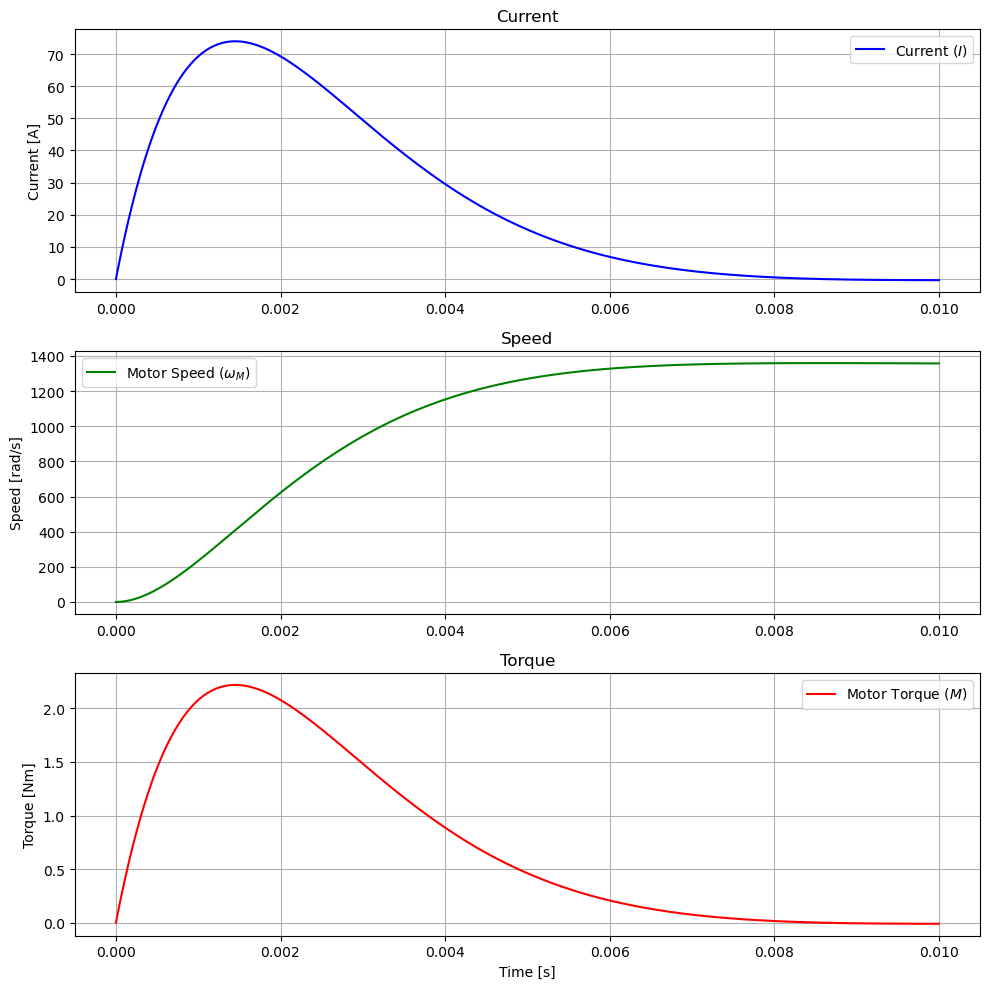

In [33]:
# Plot results
# Current plot
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.plot(t, I, label=r"Current ($I$)", color='b')
plt.ylabel("Current [A]")
plt.grid()
plt.title("Current")
plt.legend()

# Speed plot
plt.subplot(3, 1, 2)
plt.plot(t, omega_M, label=r"Motor Speed ($\omega_M$)", color='g')
plt.ylabel("Speed [rad/s]")
plt.grid()
plt.title("Speed")
plt.legend()

# Torque plot
plt.subplot(3, 1, 3)
plt.plot(t, M, label=r"Motor Torque ($M$)", color='r')
plt.ylabel("Torque [Nm]")
plt.xlabel("Time [s]")
plt.grid()
plt.title("Torque")
plt.legend()


plt.tight_layout()
plt.show()

-------------------------------